In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from copy import deepcopy
import sys; sys.path.insert(0, '../')
import mne
from scipy.sparse.csgraph import laplacian
import matplotlib.pyplot as plt
import numpy as np
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
plot_params = dict(surface='white', hemi='both', verbose=0)

In [2]:
info = get_info(sfreq=100)
fwd = create_forward_model(info=info, sampling='ico3')

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.6s remaining:    2.8s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.6s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


In [5]:
n_samples = 10
settings = dict(number_of_sources=5, extents=(1,40), duration_of_trial=0, method="noise")
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)

Simulating data based on 1/f noise.


100%|██████████| 10/10 [00:00<00:00, 10024.63it/s]

source data shape:  (1284, 1) (1284, 1)



100%|██████████| 10/10 [00:00<00:00, 833.38it/s]


In [6]:
import numpy as np
X = np.stack([source.data[:,0] for source in sim.source_data], axis=0)
X = np.stack([x / np.max(abs(x)) for x in X], axis=0)

# Autoencoder

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow import keras
import tensorflow as tf
k = 200
batch_size = 32
epochs = 100
activation='tanh'
n_samples, n_dipoles = X.shape
model = keras.Sequential(name="autoencoder")
model.add(Dense(k, activation=activation))
model.add(Dense(k, activation=activation))
model.add(Dense(n_dipoles))
model.build(input_shape=(None, n_dipoles))
model.summary()
model.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer="adam")
model.fit(X,X, epochs=epochs, batch_size=batch_size, validation_split=0.15)


# Eval

In [ ]:
n_samples = 2
settings = dict(number_of_sources=1, extents=(1,2), duration_of_trial=0)
sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)

X_test = np.stack([source.data[:,0] for source in sim_test.source_data], axis=0)
X_test = np.stack([x / np.max(abs(x)) for x in X_test], axis=0)

y_hat = model.predict(X_test)[0]

stc = sim_test.source_data[0]
stc.plot(surface="white", hemi="both")


stc_hat = stc.copy()
stc_hat.data[:, 0] = y_hat
stc_hat.plot(surface="white", hemi="both")


# GFT

Text(0.5, 1.0, 'Eigenvalues')

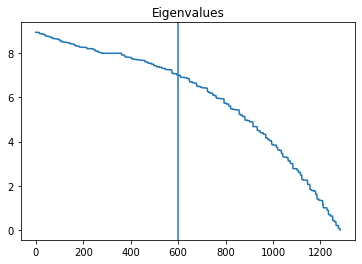

In [7]:
import mne
from scipy.sparse.csgraph import laplacian
import matplotlib.pyplot as plt
A = mne.spatial_src_adjacency(fwd["src"], verbose=0).toarray()
D = np.diag(A.sum(axis=0))
L = D-A
# L = laplacian(adj)
U, s, V = np.linalg.svd(L)

k = 600
keep = np.zeros(A.shape[0]).astype(bool)
keep[:k] = True
plt.figure()
plt.plot(s)
plt.axvline(k)
plt.title("Eigenvalues")


In [8]:
from copy import deepcopy
u = deepcopy(X[0])
k_vals = [10, 200, 500, 1000]
graph_frequencies = np.zeros(len(k_vals))


for k in k_vals:
    U, s, V = np.linalg.svd(L)
    U = U[:, :k]
    s = s[:k]
    V = V[:, :k]
    
    A_hat = U.T @ A @ U
    u_hat = U.T @ u
    n_dipoles = k

    u_hat = U[:, :k].T @ u
    for j in range(n_dipoles):
        neighbors = np.where(A_hat[j,:])[0]
        for p in neighbors:
            graph_frequencies[k] += ((u_hat[j] * u_hat[p]) < 0) / 2
        


IndexError: index 10 is out of bounds for axis 0 with size 4

In [14]:
from scipy.sparse import coo_matrix
import scipy

A = mne.spatial_src_adjacency(fwd["src"], verbose=0).toarray()
D = np.diag(A.sum(axis=0))
L = D-A

settings = dict(number_of_sources=10, extents=(1, 40), duration_of_trial=0, method="standard")
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=2)

U, s, V = np.linalg.svd(L)

perc = np.percentile(s / s.max(), 50)
k = np.where(s[::-1] > (perc * s.max()))[0][0]
print("optmal k: ", k)
k = 300
# U_hat = U[:, :k]
# s_hat = s[:k]
# V_hat = V[:, :k]
U_hat = U[:, -k:]
s_hat = s[-k:]
V_hat = V[:, -k:]

stc = sim.source_data[0]
X = stc.data[:, 0]
X /= np.max(abs(X))
stc.data[:, 0] = X
stc.plot(**plot_params, brain_kwargs=dict(title="True Source"))

X_low = U_hat.T @ deepcopy(X)
# X_low = V_hat @ X

X_back = U_hat @ X_low
X_back /= np.max(abs(X_back))
stc_hat = stc.copy()
stc_hat.data[:, 0] = X_back
stc_hat.plot(**plot_params, brain_kwargs=dict(title="Recovered Source"))


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 2017.46it/s]


source data shape:  (1284, 1) (1284, 1)


100%|██████████| 2/2 [00:00<00:00, 499.41it/s]


optmal k:  642


In [15]:
from scipy.stats import pearsonr
pearsonr(X, X_back)[0]

0.8275411445075219

In [79]:
class Compressor:
    ''' Compression using Graph Fourier Transform
    '''
    def __init__(self):
        pass
    def fit(self, fwd, k=600):
        A = mne.spatial_src_adjacency(fwd["src"], verbose=0).toarray()
        D = np.diag(A.sum(axis=0))
        L = D-A
        U, s, V = np.linalg.svd(L)

        self.U = U[:, -k:]
        self.s = s[-k:]
        self.V = V[:, -k:]

    def encode(self, X):
        ''' Encodes a true signal X
        Parameters
        ----------
        X : numpy.ndarray
            True signal
        
        Return
        ------
        X_comp : numpy.ndarray
            Compressed signal
        '''
        X_comp = self.U.T @ X

        return X_comp

    def decode(self, X_comp):
        ''' Decodes a compressed signal X

        Parameters
        ----------
        X : numpy.ndarray
            Compressed signal
        
        Return
        ------
        X_unfold : numpy.ndarray
            Decoded signal
        '''
        X_unfold = self.U @ X_comp
        return X_unfold